In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.externals import joblib

In [2]:
def get_time(x, c1, c2):     #find the difference between two date columns of dataframe x
    diff =  x[c2] - x[c1]
    days = diff.days
    days_to_hours = days * 24
    diff_btw_two_times = (diff.seconds) / 3600
    overall_hours = days_to_hours + diff_btw_two_times
    return overall_hours

In [3]:
file = 'delivery_new_nov_2018.xlsx'
data = pd.ExcelFile(file)
df = data.parse('Order History_1')

In [4]:
col_names= ['Created Time', 'Biker Assigned Time', 'Biker Accepted Time', 'Delivered Time',
           'Orders in Progress for Biker', 'Total Orders to Assign', 'Qty']
df.dropna(subset=col_names, how='any', inplace = True)
col_names= ['Created Time', 'Biker Assigned Time', 'Biker Accepted Time', 'In Bike TIme', 'Delivered Time']

In [76]:
timestamp_info = pd.DataFrame(columns=['Created Time', 'Biker Assigned Time', 'Biker Accepted Time'])
timestamp_info[col_names] = df[col_names].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')
df['Hours2deliver']= df.apply(get_time, c1='Biker Accepted Time', c2='Delivered Time', axis=1)
df['PendingOrdersLocationWise']= df['Total Orders to Assign']
#df['LocationCode'], levels = pd.factorize(df['Location Code'])
#df['BikerCode'], levels = pd.factorize(df['Biker Code'])
df['Location Code']
df['Biker Code']
df['CustomerCode'], levels = pd.factorize(df['Customer Code'])

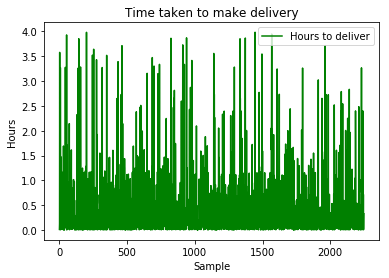

In [51]:
is_strange =  df['Hours2deliver']>4
df= df[~is_strange]
plt.plot(df['Hours2deliver'].values, color= 'green', label= 'Hours to deliver') # p
plt.ylabel('Hours')
plt.xlabel('Sample')
plt.title('Time taken to make delivery')
plt.legend()
plt.show()

In [92]:
#df = df[~is_strange]
timestamp_info = df[['Created Time', 'Biker Assigned Time', 'Biker Accepted Time']].values.astype(int)
other_features = df[['Biker Code', 'Location Code', 'PendingOrdersLocationWise']].values
X =  np.concatenate((timestamp_info, other_features), axis=1)
#X= info_taken[['BikerID', 'Hours2assign', 'Hours2accept']].values #, 
Y= np.reshape(df['Hours2deliver'].values, -1)

In [93]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=0.1)

In [105]:
tree_regression_model = tree.DecisionTreeRegressor(min_samples_split=19, max_depth=7,random_state=0)
trained_model = tree_regression_model.fit(X,Y)
joblib.dump(trained_model, 'model3_dt.sav')

['model3_dt.sav']

In [101]:
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
tree_regression_Model = tree.DecisionTreeRegressor(random_state=0)
scoring = make_scorer(r2_score)
parameters={'max_depth': np.arange(3, 25), 'min_samples_split':np.arange(5, 20)}
#cross_validation = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(tree_regression_Model, parameters, cv=20, n_jobs=5, scoring=scoring,verbose=1)

In [87]:
grid_search.fit(X_trn,Y_trn)

Fitting 20 folds for each of 330 candidates, totalling 6600 fits


[Parallel(n_jobs=5)]: Done 1210 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 6600 out of 6600 | elapsed:   15.9s finished


GridSearchCV(cv=20, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'),
       fit_params={}, iid=True, n_jobs=5,
       param_grid={'min_samples_split': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24])},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(r2_score),
       verbose=1)

In [88]:
print(grid_search.best_params_)
print(grid_search.best_estimator_.feature_importances_)

{'min_samples_split': 19, 'max_depth': 7}
[0.14344864 0.15425928 0.23752098 0.31455457 0.13638108 0.01383544]


In [106]:
predict_model = trained_model.predict(X_tst)
#predict_model = grid_search.best_estimator_.predict(X_tst)

In [107]:
print("Mean squared error: "  )
mse= mean_squared_error(Y_tst, predict_model)
print(mse)

print('r2')
print(r2_score(Y_tst, predict_model, sample_weight=None, multioutput='uniform_average'))

Mean squared error: 
0.1804202990532448
r2
0.5871533073979446


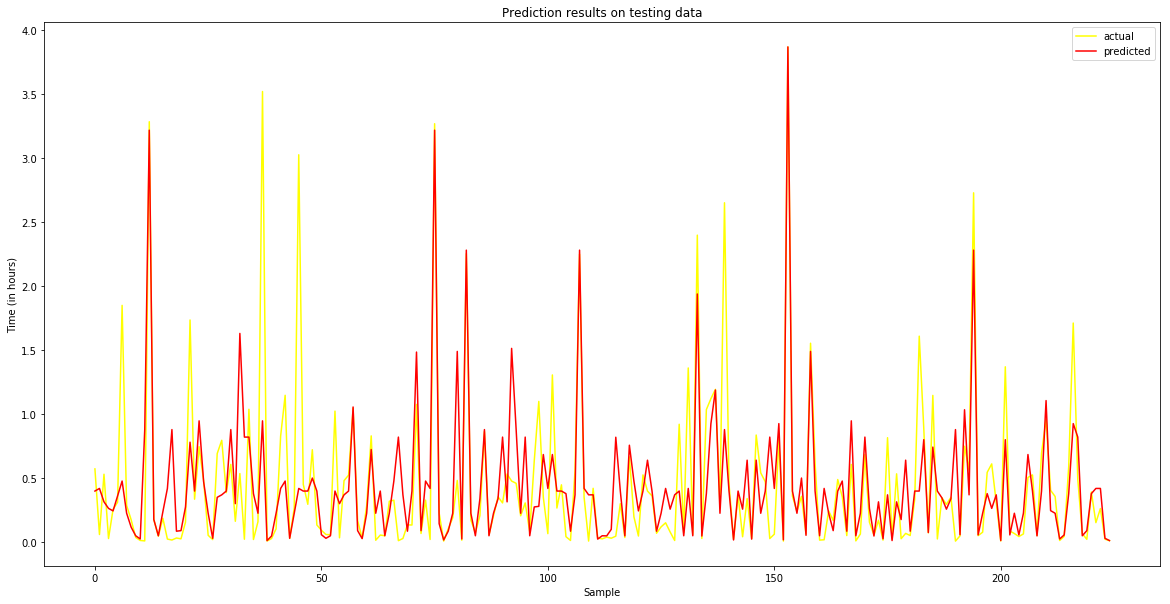

In [108]:
plt.figure(figsize=(20,10))
plt.plot(Y_tst, color= 'yellow', label= 'actual') # p
plt.plot(predict_model, color= 'red', label= 'predicted') # p
plt.xlabel('Sample')
plt.ylabel('Time (in hours)')
plt.title('Prediction results on testing data')
plt.legend()
plt.show()

<H2> Convert time in to 2 dimension (sine and cosine) because of cyclic nature of time <H2>

In [49]:
df['created_week'], created_day, df['BikerAcceptedTime'] = zip(*[(d.dayofweek, d.date().day, 
                                                 d.date()) for d in df['Biker Accepted Time']])

In [5]:
df['deliver_week'], deliver_day, df['deliver_time'] = zip(*[(d.dayofweek, d.date().day, d.date()) 
                                                                    for d in df['Delivered Time']])

In [50]:
df['diff'] = df['Biker Accepted Time'] - df['BikerAcceptedTime'].apply(pd.to_datetime)

In [51]:
df['seconds'] = df['diff'].dt.total_seconds()

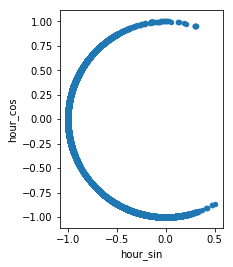

In [52]:
df['hour_sin'] = np.sin(2 * np.pi * df['seconds']/86400.0)
df['hour_cos'] = np.cos(2 * np.pi * df['seconds']/86400.0)
df.plot.scatter('hour_sin','hour_cos').set_aspect('equal');

In [9]:
df['del_diff'] = df['Delivered Time'] - df['deliver_time'].apply(pd.to_datetime)
df['del_seconds'] = df['del_diff'].dt.total_seconds() 

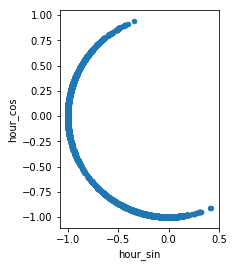

In [10]:
df['del_sin'] = np.sin(2 * np.pi * df['del_seconds']/86400.0)
df['del_cos'] = np.cos(2 * np.pi * df['del_seconds']/86400.0)
df.plot.scatter('hour_sin','hour_cos').set_aspect('equal');

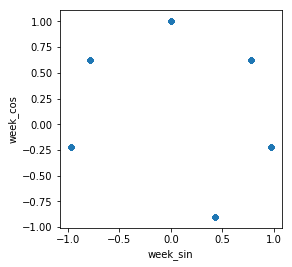

In [11]:
df['week_sin'] = np.sin(2 * np.pi * df['created_week']/7.0)
df['week_cos'] = np.cos(2 * np.pi * df['created_week']/7.0)
df.plot.scatter('week_sin','week_cos').set_aspect('equal');

In [53]:
X = df[['hour_sin', 'hour_cos', 'LocationCode', 'CustomerCode', 'BikerCode', 'Orders in Progress for Biker', 'Total Orders to Assign', 'Qty']].values
#Y = df[['del_sin', 'del_cos']].values
Y = df['Hours2deliver'].values 
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=0.3, random_state=42)

In [33]:
tree_regression_model = tree.DecisionTreeRegressor(max_depth= 8, min_samples_split= 14)
trained_model = tree_regression_model.fit(X_trn, Y_trn)

In [34]:
predict_model = trained_model.predict(X_tst)

In [60]:
print("Mean squared error: "  )
mse= mean_squared_error(Y_tst, predict_model,)
print(mse)

print('r2')
r2 = r2_score(Y_tst, predict_model, sample_weight=None, multioutput='uniform_average')
print(r2)
adj_r2 = 1-(1-r2) * (X_tst.shape[0] -1)/(X_tst.shape[0]-X_tst.shape[1] -1)
adj_r2

Mean squared error: 
0.24885923885327899
r2
0.15629211343108385


0.15465145638379374

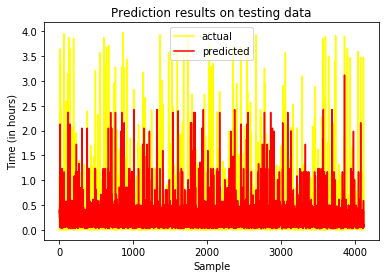

In [61]:
plt.plot(Y_tst, color= 'yellow', label= 'actual') # p
plt.plot(predict_model, color= 'red', label= 'predicted') # p
plt.xlabel('Sample')
plt.ylabel('Time (in hours)')
plt.title('Prediction results on testing data')
plt.legend()
plt.show()

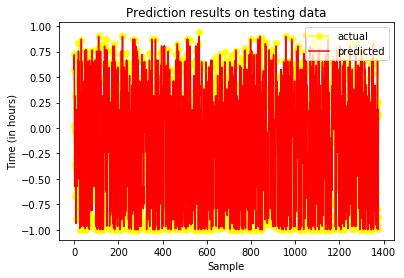

In [19]:
plt.plot(Y_tst[:,1], color= 'yellow',marker='o', label= 'actual') # p
plt.plot(predict_model[:,1], color= 'red', label= 'predicted') # p
plt.xlabel('Sample')
plt.ylabel('Time (in hours)')
plt.title('Prediction results on testing data')
plt.legend()
plt.show()

In [20]:
total_seconds = 60*60*24
sine_sec = np.abs((np.arcsin(predict_model[:,0]))*(total_seconds/2*np.pi))
sine_autal_sec = np.abs((np.arcsin(Y_tst[:,0]))*(total_seconds/2*np.pi))
cosine_sec = np.abs((np.arcsin(predict_model[:,1]))*(total_seconds/2*np.pi))
cosine_autal_sec = np.abs((np.arcsin(Y_tst[:,1]))*(total_seconds/2*np.pi))
df1 = pd.DataFrame()
df1['sine_sec'] = sine_sec
df1['sine_autal_sec'] = sine_autal_sec
df1['cosine_sec'] = cosine_sec
df1['cosine_autal_sec'] = cosine_autal_sec
df1.to_csv('model3_time_comparison.csv', sep=',', index=False)